In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.dates as mdates

/tmp/ipykernel_11344/727316262.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
ds = np.load("dataset_24h.npy", allow_pickle=True)

In [5]:
print(ds.shape)
ds.item().get("72492570")[0][:10]

()


[(157, datetime.datetime(2016, 8, 5, 5, 46, 46)),
 (154, datetime.datetime(2016, 8, 5, 5, 51, 53)),
 (153, datetime.datetime(2016, 8, 5, 5, 56, 47)),
 (151, datetime.datetime(2016, 8, 5, 6, 1, 47)),
 (148, datetime.datetime(2016, 8, 5, 6, 6, 47)),
 (148, datetime.datetime(2016, 8, 5, 6, 11, 48)),
 (157, datetime.datetime(2016, 8, 5, 6, 21, 47)),
 (157, datetime.datetime(2016, 8, 5, 6, 26, 49)),
 (156, datetime.datetime(2016, 8, 5, 6, 31, 48)),
 (127, datetime.datetime(2016, 8, 5, 7, 6, 51))]

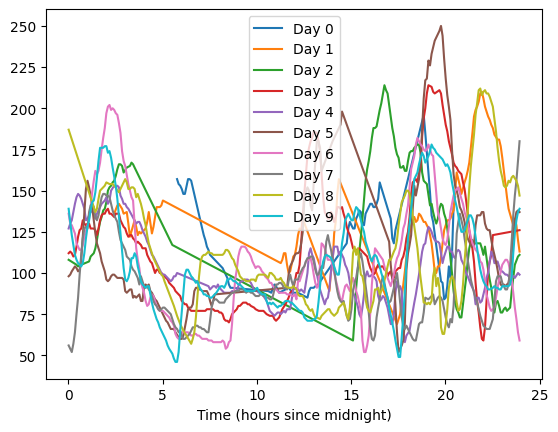

In [6]:

fig, ax = plt.subplots()

for i in range(10):
    day_data = ds.item().get("72492570")[i]
    bg = [t[0] for t in day_data]  # Blood glucose levels
    datetimes = [t[1] for t in day_data]  

    # Convert datetimes to hours
    hours = [t.hour + t.minute / 60.0 for t in datetimes]


    # Convert seconds to hours
    #hours = np.array(seconds) / 3600.0

    ax.plot(hours, bg, label=f"Day {i}")

# Formatting the x-axis to show hours
ax.set_xlabel('Time (hours since midnight)')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


In [15]:
# get the data into a df with the following columns:
# data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%S')
# data['Glucose'] = pd.to_numeric(df['Glucose Value (mg/dL)']) <- change this with the name of your glucose column
# data['Day'] = data['Time'].datetime.date data = data.reset_index()

data = pd.DataFrame(columns=['Time', 'Glucose', 'Day'])
for patient in ds.item():
    for day in ds.item().get(patient):
        patient_list = []
        patient_id = patient
        for i in range(len(day)):
            # append the data to a list
            patient_list.append({'Time': day[i][1], 'Glucose': day[i][0], 'Day': day[i][1].date()})

        # concat the list to the dataframe setting the patient id as the index
        data = pd.concat([data, pd.DataFrame(patient_list, index=[patient_id]*len(patient_list))])

print(data.head())

/tmp/ipykernel_11344/3137564970.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame(patient_list, index=[patient_id]*len(patient_list))])


                        Time Glucose         Day
72492570 2016-08-05 05:46:46     157  2016-08-05
72492570 2016-08-05 05:51:53     154  2016-08-05
72492570 2016-08-05 05:56:47     153  2016-08-05
72492570 2016-08-05 06:01:47     151  2016-08-05
72492570 2016-08-05 06:06:47     148  2016-08-05


In [35]:

class Metrics:
    """A custom class for diabetes-related metrics"""

    def __init__(self, df):
        self.df = df.copy()

    def tar(self, threshold_high=180):
        # Create a new column in the DataFrame that is True where 'Glucose' is above the threshold and False otherwise
        self.df['HighGlucose'] = self.df['Glucose'] >= threshold_high

        # Group by 'Day' and calculate the mean of 'HighGlucose'. This works because True is treated as 1 and False as 0.
        tar_series = self.df.groupby('Day')['HighGlucose'].mean() * 100

        # Convert the resulting Series to a list
        tar_list = tar_series.tolist()

        # Remove the 'HighGlucose' column from the DataFrame
        self.df.drop('HighGlucose', axis=1, inplace=True)

        return tar_list

    def tbr(self, threshold_low=70):
        # Create a new column in the DataFrame that is True where 'Glucose' is below the threshold and False otherwise
        self.df['LowGlucose'] = self.df['Glucose'] <= threshold_low

        # Group by 'Day' and calculate the mean of 'LowGlucose'. This works because True is treated as 1 and False as 0.
        tbr_series = self.df.groupby('Day')['LowGlucose'].mean() * 100

        # Convert the resulting Series to a list
        tbr_list = tbr_series.tolist()

        # Remove the 'LowGlucose' column from the DataFrame
        self.df.drop('LowGlucose', axis=1, inplace=True)

        return tbr_list
    
    
    def tir(self, threshold_low=70, threshold_high=180):
        # Create a new column in the DataFrame that is True where 'Glucose' is between the thresholds and False otherwise
        self.df['InRange'] = np.logical_and(self.df['Glucose'] > threshold_low, self.df['Glucose'] <= threshold_high)

        # Group by 'Day' and calculate the mean of 'InRange'. This works because True is treated as 1 and False as 0.
        tir_series = self.df.groupby('Day')['InRange'].mean() * 100

        # Convert the resulting Series to a list
        tir_list = tir_series.tolist()

        # Remove the 'InRange' column from the DataFrame
        self.df.drop('InRange', axis=1, inplace=True)

        return tir_list

    def gri(self):
        low_list = np.array(self.tir_new(54, 70))
        vlow_list = np.array(self.tbr_new(54))
        high_list = np.array(self.tir_new(180, 250))
        vhigh_list = np.array(self.tar_new(250))
        gri_list = 3 * (vlow_list) + 2.4 * (low_list) + 1.6 * (vhigh_list) + 0.8 * (high_list)

        return gri_list


GRI: [ 1.81818182 13.45132743  8.75        9.96108949  5.82995951 29.84771574
 46.43939394 45.         15.47325103 19.85130112 42.96296296 11.38686131
  9.10569106 21.94690265  9.66037736 14.30656934  4.49438202 23.76811594
  7.56363636  1.03448276  4.81203008  5.73991031 13.68821293  3.56877323
  3.60902256  7.13754647  4.08510638  2.63736264  3.37164751  4.44444444
 39.13043478 26.06741573 10.73359073  1.99170124  0.         16.15384615
 41.54506438  5.78313253  2.44274809  0.          0.          4.84848485
  5.90405904 17.20164609 18.72       22.34817814  0.          2.75862069
  4.14814815  2.69662921  2.8685259  41.06463878  3.98340249 37.00729927
 19.45945946 23.42007435 14.80916031 25.49707602  8.46715328  3.62264151
  3.95437262  2.57142857 18.50980392 15.19379845 21.26984127 12.09302326
  6.90647482  4.37956204  6.59498208  9.46236559  7.30038023  8.14070352
  3.21167883  5.95588235  1.77121771  6.66666667  2.94117647  8.
 13.11004785  4.54545455 18.46153846 18.04878049 13.38

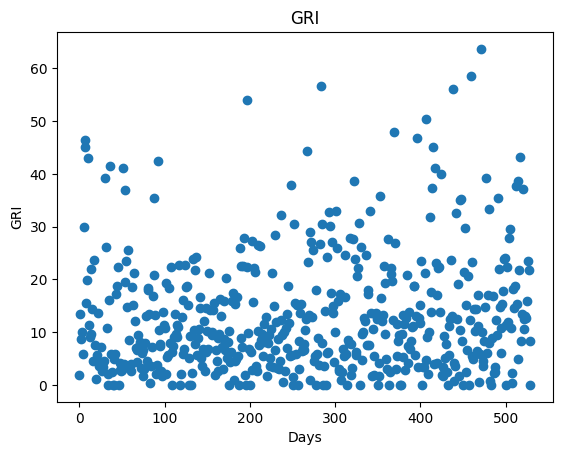

In [40]:
# get the metrics for just one patient
metrics = Metrics(data.loc['72492570'])

#tbr = metrics.tbr()
gri = metrics.gri()
#print(f'TAR: {tar}%')
print(f'GRI: {gri}')

# plot the gri scatter plot
plt.scatter(range(len(gri)), gri)
plt.title('GRI')
plt.xlabel('Days')
plt.ylabel('GRI')
plt.show()


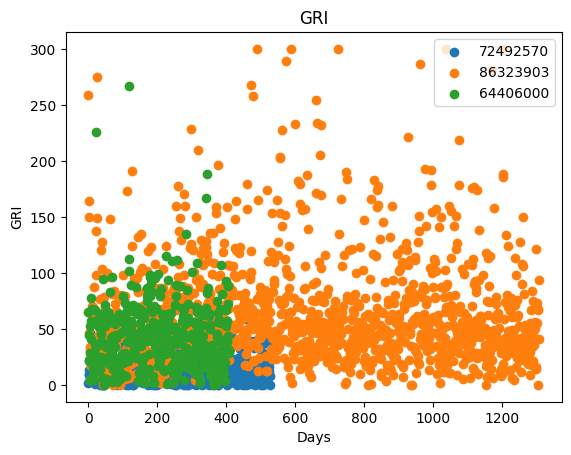

In [41]:
# for each patient, get the gri and plot against the others
gri_list = []
for patient in ds.item():
    metrics = Metrics(data.loc[patient])
    gri = metrics.gri()
    gri_list.append(gri)

# plot the gri scatter plot
for i, patient in enumerate(ds.item()):
    plt.scatter(range(len(gri_list[i])), gri_list[i], label=patient)

plt.legend()
plt.title('GRI')
plt.xlabel('Days')
plt.ylabel('GRI')
plt.show()


In [ ]:
# some days are missing data
# fill in missing data with the mean of the current day

time_stamps = np.arange(0, 24 * 3600, 60 * 5)
print((time_stamps))
def fill_missing_data(day_data):
    bg = [t[0] for t in day_data]  # Blood glucose levels
    mean = np.mean(bg)
    seconds = np.array([t[1] for t in day_data])  # Seconds of the day
    print(seconds)

    # Convert seconds to hours
    # hours = np.array(seconds) / 3600.0

    # just use the mean for missing data
    zeros = np.zeros_like(time_stamps)
    # find the indices to fill
    indices = np.searchsorted(time_stamps, seconds, side='left') -1
    indices[indices == 288] = 287
    # fill the data
    zeros[indices] = bg
    # fill in the missing data with the mean
    zeros[zeros == 0] = mean


    # Return the interpolated data
    return zeros

# test it on day 0
day_data = ds.item().get("72492570")[2]
interpolated_bg = fill_missing_data(day_data)

# Plot the original and interpolated data
plt.scatter(time_stamps / 3600.0, interpolated_bg, label='interpolated')
plt.scatter([t[1] / 3600.0 for t in day_data], [t[0] for t in day_data], label='original')
plt.show()
